<a href="https://colab.research.google.com/github/seenu-g/Experiments/blob/master/code/TrialV5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-fr9w0__b
Albumentation library is successfully installed!


In [2]:
# mount gdrive and unzip data
from google.colab import drive
import sys
%load_ext autoreload
%autoreload 2
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [17]:
import sys
import os
folder = '/content/gdrive/My Drive/school_of_ai/chap10/'
os.chdir(folder)
print(os.getcwd()) 
for root, dirs, files in os.walk("."):
    for filename in files:
        print(filename)
sys.path.append(folder)

/content/gdrive/My Drive/school_of_ai/chap10
TrialV5.ipynb
bestmodel.pt
gradcam.py
load_data.py
model.py
show_images.py
__init__.py
transforms.py
lr_finder.py
evaluate.py
train_test.py
plot.py
__init__.cpython-36.pyc
load_data.cpython-36.pyc
show_images.cpython-36.pyc
model.cpython-36.pyc
train_test.cpython-36.pyc
evaluate.cpython-36.pyc
transforms.cpython-36.pyc
gradcam.cpython-36.pyc
lr_finder.cpython-36.pyc
plot.cpython-36.pyc
cifar-10-python.tar.gz
data_batch_4
readme.html
test_batch
data_batch_3
batches.meta
data_batch_2
data_batch_5
data_batch_1


In [0]:
%matplotlib inline
import torch
from template import load_data
from template import show_images
from template import model
from template import train_test
from template import evaluate
from template import transforms
from template import gradcam
from template import lr_finder
from template import plot

In [0]:
import albumentations as A
train_transform_list = [
                          A.Rotate((-30.0, 30.0)),
                          A.HorizontalFlip(),
                          A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                          A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                          A.Cutout(num_holes=2, max_h_size=9,max_w_size = 9,p=0.7) # fillvalue is 0 after normalizing as mean is 0
                       ]
test_transform_list = [A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
train_transform = transforms.AlbumentationTransforms(train_transform_list)
test_transform = transforms.AlbumentationTransforms(test_transform_list)

In [20]:
classes, trainloader, testloader = load_data.load(train_transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


**Some Training Data**

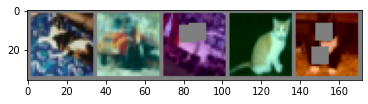

In [21]:
show_images.show_images(trainloader, classes)

**Print Model Summary**

In [22]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [23]:
pip install --no-cache-dir git+https://github.com/NVIDIA/apex > /dev/null && echo "Apex library is successfully installed!"

  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-6b8v5715
  Running command git submodule update --init --recursive -q
Apex library is successfully installed!


**LR Finder - Finds the best possible LR**


In [26]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR , MultiStepLR

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.0001)
lrfinder = lr_finder.LRFinder(model, optimiser, criterion, device="cuda")
lrfinder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=600 ,step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


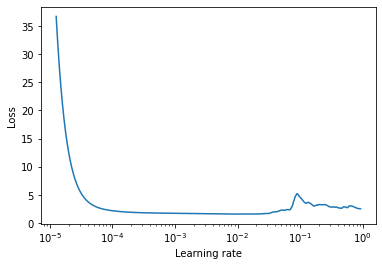

In [30]:
lrfinder.plot()

In [31]:
best_lr = lrfinder.history['lr'][lrfinder.history['loss'].index(lrfinder.best_loss)]
print(best_lr)

0.007356422544596416


In [0]:
lrfinder.reset()

**Initialise Loss funtion, Optimizer, Scheduler**

In [33]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR , MultiStepLR, ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_lr,momentum=0.9 ,weight_decay = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, patience = 3,min_lr=1e-4)
print(optimizer.param_groups[0]['lr'])

0.007356422544596416


**Train the Model for 50 Epochs**

In [34]:
test_loss = []
test_acc = []
train_loss = []
train_acc = []
EPOCHS = 50
best_acc = 0
for epoch in range(EPOCHS):
     print("\n EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_loss, train_acc = train_test.train(model, device, trainloader, optimizer, criterion, epoch)
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)
     scheduler.step(test_loss[-1])
     if(test_acc[-1]>best_acc):
       print("accuracy increased, Saving model....")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/school_of_ai/chap10/bestmodel.pt")

  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 1 LR: 0.007356422544596416


Loss=2.274406909942627 Batch_id=0 Accuracy=17.97:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.3830, Accuracy: 1121/10000 (11.21%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 2 LR: 0.007356422544596416


Loss=2.565876007080078 Batch_id=0 Accuracy=17.97:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.2047, Accuracy: 1218/10000 (12.18%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 3 LR: 0.007356422544596416


Loss=2.037437915802002 Batch_id=0 Accuracy=33.59:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.1037, Accuracy: 1429/10000 (14.29%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 4 LR: 0.007356422544596416


Loss=2.1948890686035156 Batch_id=0 Accuracy=22.66:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0553, Accuracy: 2101/10000 (21.01%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 5 LR: 0.007356422544596416


Loss=1.9381225109100342 Batch_id=0 Accuracy=29.69:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0356, Accuracy: 2365/10000 (23.65%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 6 LR: 0.007356422544596416


Loss=1.8833682537078857 Batch_id=0 Accuracy=26.56:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0287, Accuracy: 2435/10000 (24.35%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 7 LR: 0.007356422544596416


Loss=2.0512733459472656 Batch_id=0 Accuracy=27.34:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 2430/10000 (24.30%)


 EPOCH: 8 LR: 0.007356422544596416


Loss=2.0403382778167725 Batch_id=0 Accuracy=26.56:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0223, Accuracy: 2546/10000 (25.46%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 9 LR: 0.007356422544596416


Loss=1.9948852062225342 Batch_id=0 Accuracy=28.91:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0190, Accuracy: 2791/10000 (27.91%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 10 LR: 0.007356422544596416


Loss=1.9770740270614624 Batch_id=0 Accuracy=28.12:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0174, Accuracy: 2867/10000 (28.67%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 11 LR: 0.007356422544596416


Loss=1.8997234106063843 Batch_id=0 Accuracy=30.47:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0171, Accuracy: 2877/10000 (28.77%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 12 LR: 0.007356422544596416


Loss=2.153712034225464 Batch_id=0 Accuracy=25.00:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0165, Accuracy: 3063/10000 (30.63%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 13 LR: 0.007356422544596416


Loss=2.0068881511688232 Batch_id=0 Accuracy=27.34:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0156, Accuracy: 3347/10000 (33.47%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 14 LR: 0.007356422544596416


Loss=1.9776920080184937 Batch_id=0 Accuracy=26.56:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0149, Accuracy: 3488/10000 (34.88%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 15 LR: 0.007356422544596416


Loss=1.880556344985962 Batch_id=0 Accuracy=32.03:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 3484/10000 (34.84%)


 EPOCH: 16 LR: 0.007356422544596416


Loss=2.0149073600769043 Batch_id=0 Accuracy=28.12:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0145, Accuracy: 3502/10000 (35.02%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 17 LR: 0.007356422544596416


Loss=1.9256163835525513 Batch_id=0 Accuracy=28.91:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0141, Accuracy: 3530/10000 (35.30%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 18 LR: 0.007356422544596416


Loss=1.9193565845489502 Batch_id=0 Accuracy=26.56:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 3440/10000 (34.40%)


 EPOCH: 19 LR: 0.007356422544596416


Loss=1.7481385469436646 Batch_id=0 Accuracy=33.59:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 3387/10000 (33.87%)


 EPOCH: 20 LR: 0.007356422544596416


Loss=1.7525755167007446 Batch_id=0 Accuracy=30.47:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0142, Accuracy: 3297/10000 (32.97%)


 EPOCH: 21 LR: 0.007356422544596416


Loss=2.006183385848999 Batch_id=0 Accuracy=25.00:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 3282/10000 (32.82%)


 EPOCH: 22 LR: 0.007356422544596416


Loss=1.7546825408935547 Batch_id=0 Accuracy=32.81:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 3445/10000 (34.45%)


 EPOCH: 23 LR: 0.007356422544596416


Loss=1.6938021183013916 Batch_id=0 Accuracy=34.38:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0139, Accuracy: 3536/10000 (35.36%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 24 LR: 0.007356422544596416


Loss=1.7876847982406616 Batch_id=0 Accuracy=32.81:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0139, Accuracy: 3589/10000 (35.89%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 25 LR: 0.007356422544596416


Loss=1.883586049079895 Batch_id=0 Accuracy=31.25:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0137, Accuracy: 3644/10000 (36.44%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 26 LR: 0.007356422544596416


Loss=1.7891464233398438 Batch_id=0 Accuracy=36.72:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 3636/10000 (36.36%)


 EPOCH: 27 LR: 0.007356422544596416


Loss=1.9154646396636963 Batch_id=0 Accuracy=34.38:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 3612/10000 (36.12%)


 EPOCH: 28 LR: 0.007356422544596416


Loss=1.9044718742370605 Batch_id=0 Accuracy=35.16:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0134, Accuracy: 3679/10000 (36.79%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 29 LR: 0.007356422544596416


Loss=1.8728437423706055 Batch_id=0 Accuracy=28.91:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0133, Accuracy: 3757/10000 (37.57%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 30 LR: 0.007356422544596416


Loss=1.8249553442001343 Batch_id=0 Accuracy=31.25:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0133, Accuracy: 3777/10000 (37.77%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 31 LR: 0.007356422544596416


Loss=1.7235721349716187 Batch_id=0 Accuracy=35.94:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 3739/10000 (37.39%)


 EPOCH: 32 LR: 0.007356422544596416


Loss=1.7269117832183838 Batch_id=0 Accuracy=41.41:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 3744/10000 (37.44%)


 EPOCH: 33 LR: 0.007356422544596416


Loss=1.789204716682434 Batch_id=0 Accuracy=31.25:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0134, Accuracy: 3823/10000 (38.23%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 34 LR: 0.007356422544596416


Loss=1.7788395881652832 Batch_id=0 Accuracy=29.69:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0133, Accuracy: 3882/10000 (38.82%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 35 LR: 0.007356422544596416


Loss=1.923127293586731 Batch_id=0 Accuracy=27.34:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0132, Accuracy: 3984/10000 (39.84%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 36 LR: 0.007356422544596416


Loss=1.7972577810287476 Batch_id=0 Accuracy=36.72:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0131, Accuracy: 3965/10000 (39.65%)


 EPOCH: 37 LR: 0.007356422544596416


Loss=1.7255399227142334 Batch_id=0 Accuracy=34.38:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 3893/10000 (38.93%)


 EPOCH: 38 LR: 0.007356422544596416


Loss=1.7603094577789307 Batch_id=0 Accuracy=38.28:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 3854/10000 (38.54%)


 EPOCH: 39 LR: 0.007356422544596416


Loss=1.7293891906738281 Batch_id=0 Accuracy=34.38:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 3831/10000 (38.31%)


 EPOCH: 40 LR: 0.007356422544596416


Loss=1.7412874698638916 Batch_id=0 Accuracy=33.59:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 3826/10000 (38.26%)


 EPOCH: 41 LR: 0.0007356422544596416


Loss=1.8159867525100708 Batch_id=0 Accuracy=35.16:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 3858/10000 (38.58%)


 EPOCH: 42 LR: 0.0007356422544596416


Loss=1.701564073562622 Batch_id=0 Accuracy=34.38:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 3868/10000 (38.68%)


 EPOCH: 43 LR: 0.0007356422544596416


Loss=1.8132179975509644 Batch_id=0 Accuracy=30.47:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 3907/10000 (39.07%)


 EPOCH: 44 LR: 0.0007356422544596416


Loss=1.6782073974609375 Batch_id=0 Accuracy=37.50:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0131, Accuracy: 3927/10000 (39.27%)


 EPOCH: 45 LR: 0.0007356422544596416


Loss=1.8501092195510864 Batch_id=0 Accuracy=32.03:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0130, Accuracy: 3933/10000 (39.33%)


 EPOCH: 46 LR: 0.0007356422544596416


Loss=1.763883352279663 Batch_id=0 Accuracy=34.38:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0130, Accuracy: 3952/10000 (39.52%)


 EPOCH: 47 LR: 0.0007356422544596416


Loss=1.7739475965499878 Batch_id=0 Accuracy=34.38:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0130, Accuracy: 3997/10000 (39.97%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 48 LR: 0.0007356422544596416


Loss=1.7995387315750122 Batch_id=0 Accuracy=29.69:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0129, Accuracy: 4000/10000 (40.00%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 49 LR: 0.0007356422544596416


Loss=1.7105096578598022 Batch_id=0 Accuracy=39.06:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0128, Accuracy: 4019/10000 (40.19%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 50 LR: 0.0007356422544596416


Loss=1.7438539266586304 Batch_id=0 Accuracy=34.38:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0128, Accuracy: 4032/10000 (40.32%)

accuracy increased, Saving model....


**Load the Best Accuracy Model**


In [35]:
optimizer = optim.SGD(model.parameters(), lr=best_lr,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/school_of_ai/chap10/bestmodel.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


In [36]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 40 %


In [37]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 43 %
Accuracy of   car : 65 %
Accuracy of  bird :  3 %
Accuracy of   cat : 11 %
Accuracy of  deer : 38 %
Accuracy of   dog : 46 %
Accuracy of  frog : 38 %
Accuracy of horse : 48 %
Accuracy of  ship : 47 %
Accuracy of truck : 28 %


**Plot Loss Change in test**


Text(0.5, 1.0, 'Test Accuracy')

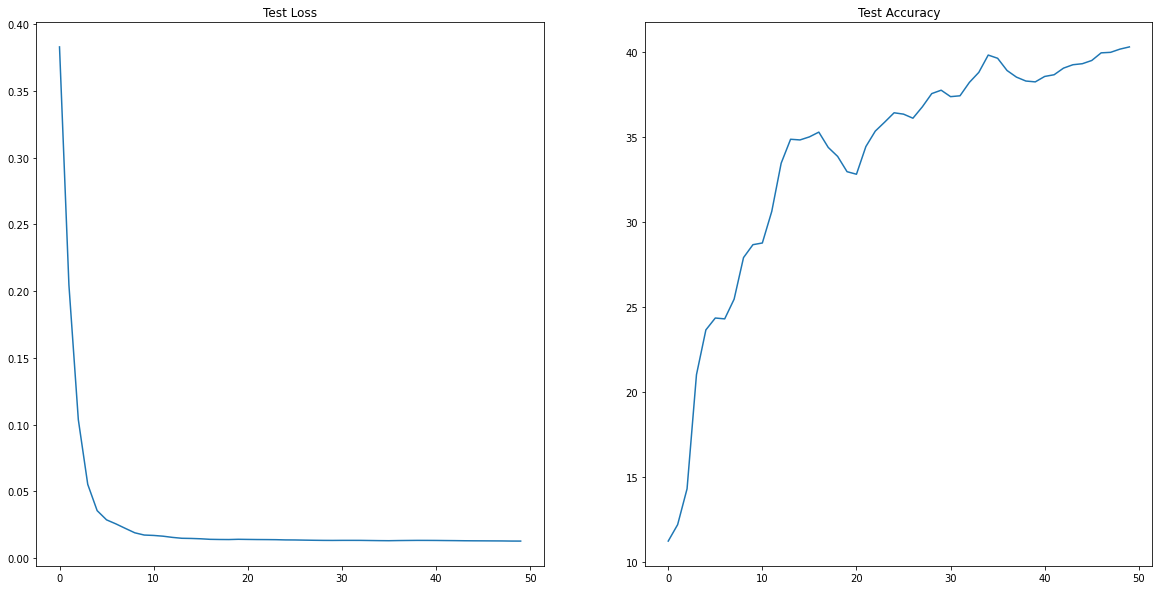

In [38]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(test_loss)
axs[0].set_title("Test Loss")

axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")

**Plot Loss Change in train**


Text(0.5, 1.0, 'Train Accuracy')

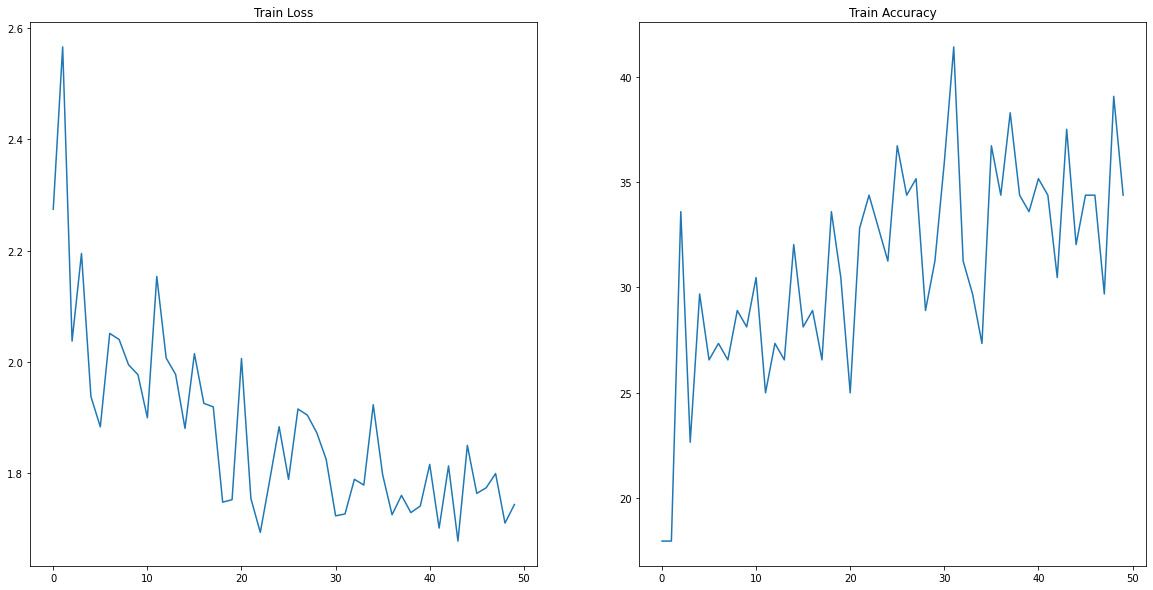

In [39]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(train_loss)
axs[0].set_title("Train Loss")

axs[1].plot(train_acc)
axs[1].set_title("Train Accuracy")

**Plot changes in Training and Test accuracy**

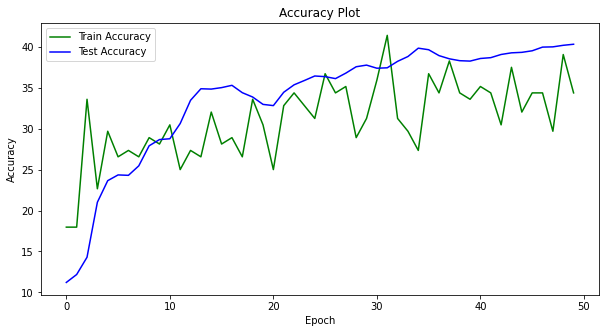

In [40]:
plot.plot_train_test_accuracy(train_acc,test_acc)

In [0]:
import shutil
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

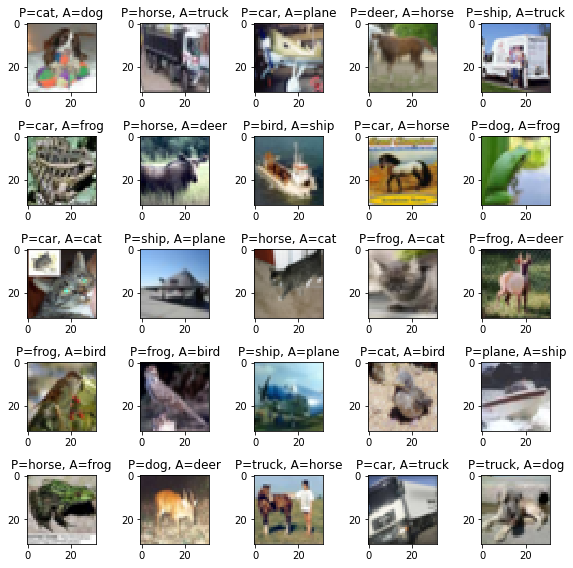

In [42]:
misclassified_images = evaluate.show_misclassified_images(model, device, testloader, classes)

**GradCam View of misclassified images(for all 4 layers)**


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


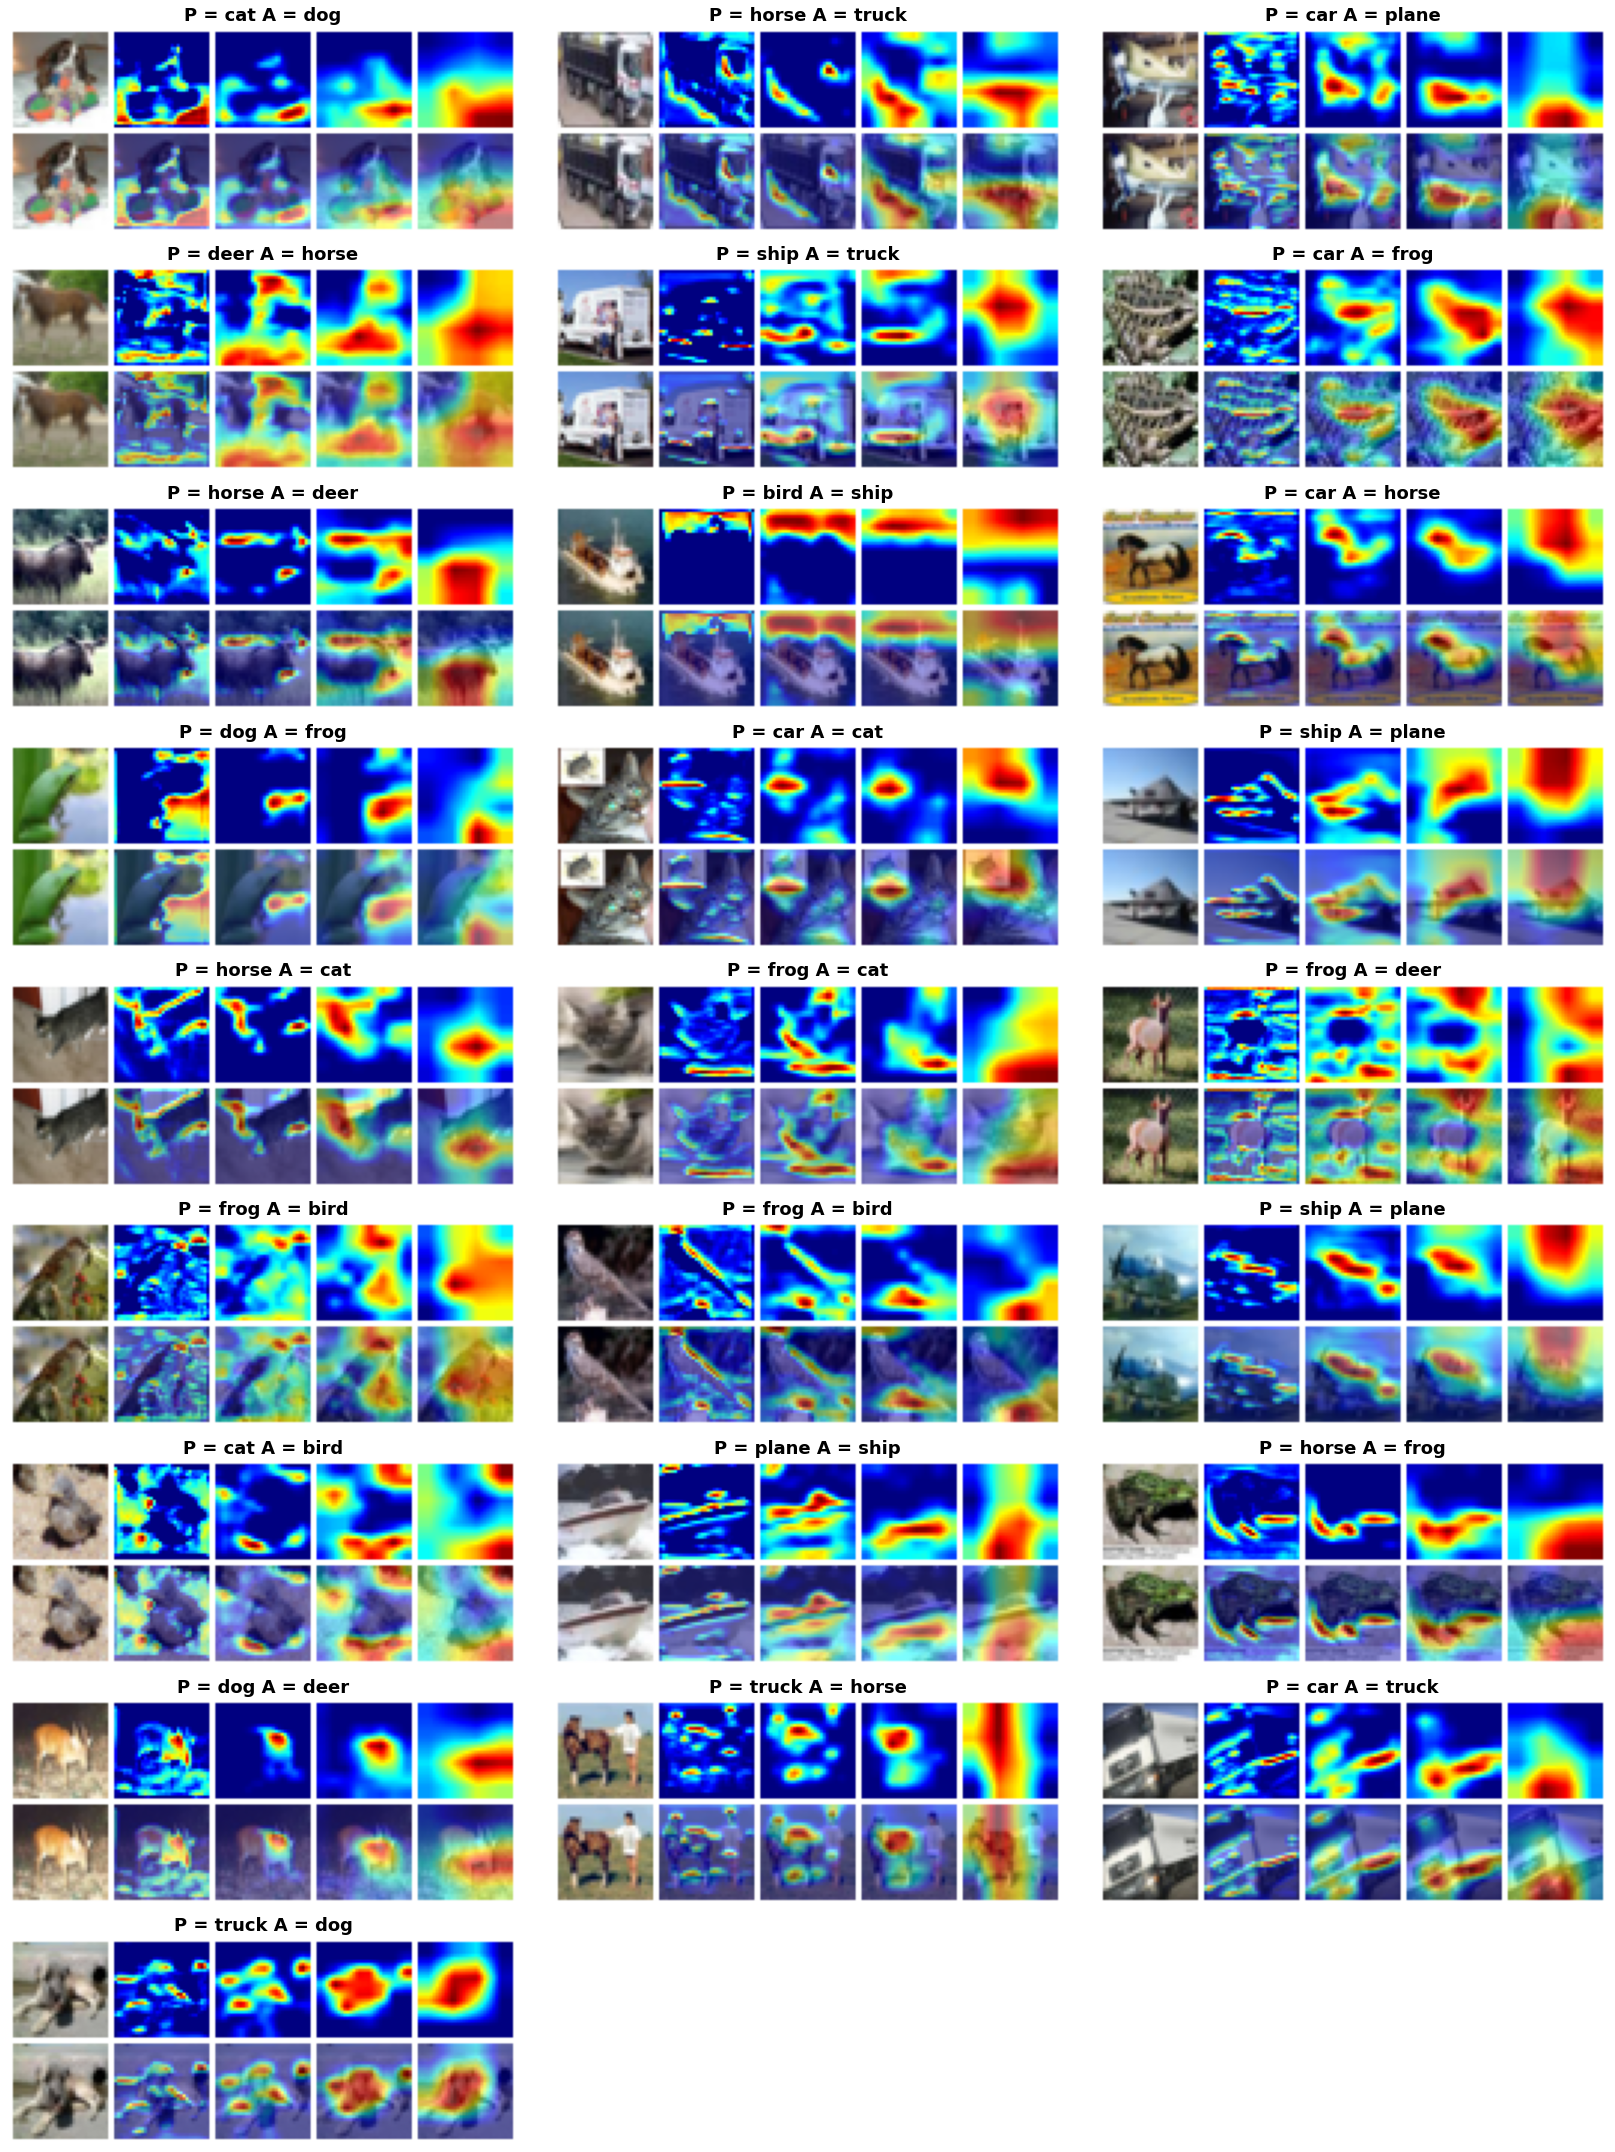

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.utils import make_grid, save_image
fig = plt.figure(figsize=(23,30))
for i,k in enumerate(misclassified_images):
  images1 = [misclassified_images[i][0].cpu()/2+0.5]
  images2 =  [misclassified_images[i][0].cpu()/2+0.5]
  b = model.to(device)
  # output = model(misclassified_images[i][0])
  # _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [model.layer1,model.layer2,model.layer3,model.layer4]
  for j in layers:
    g = gradcam.GradCAM(b,j)
    mask, _= g(misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = gradcam.visualize_cam(mask,misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5,pad_value=1)
  npimg = grid_image.numpy()
  sub = fig.add_subplot(9, 3, i+1) 
 
  # fig.subplots_adjust(wspace=0)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  sub.set_title('P = '+classes[int(misclassified_images[i][1])]+" A = "+classes[int(misclassified_images[i][2])],fontweight="bold",fontsize=18)
  sub.axis("off")
plt.tight_layout()
fig.subplots_adjust(wspace=0)